In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

from hmmlearn.hmm import GaussianHMM

In [57]:
df = pd.read_csv('../data/time_series_15min_singleindex.csv')
df = df[['cet_cest_timestamp', 'DE_50hertz_wind_generation_actual']]
df.columns = ['Timestamp', 'Value']
df.index = pd.to_datetime(df['Timestamp'], utc=True)
df = df.drop('Timestamp', axis=1)
df = df[df.index.year >= 2007]
df = df.fillna(df.rolling(24*4, min_periods=1).median())
df

,Value
Timestamp,
2007-01-01 00:00:00+00:00,5148.000
2007-01-01 00:15:00+00:00,5284.000
2007-01-01 00:30:00+00:00,5423.000
2007-01-01 00:45:00+00:00,5608.000
2007-01-01 01:00:00+00:00,5661.000
...,...
2019-04-30 22:45:00+00:00,2556.719
2019-04-30 23:00:00+00:00,2500.904
2019-04-30 23:15:00+00:00,2503.766


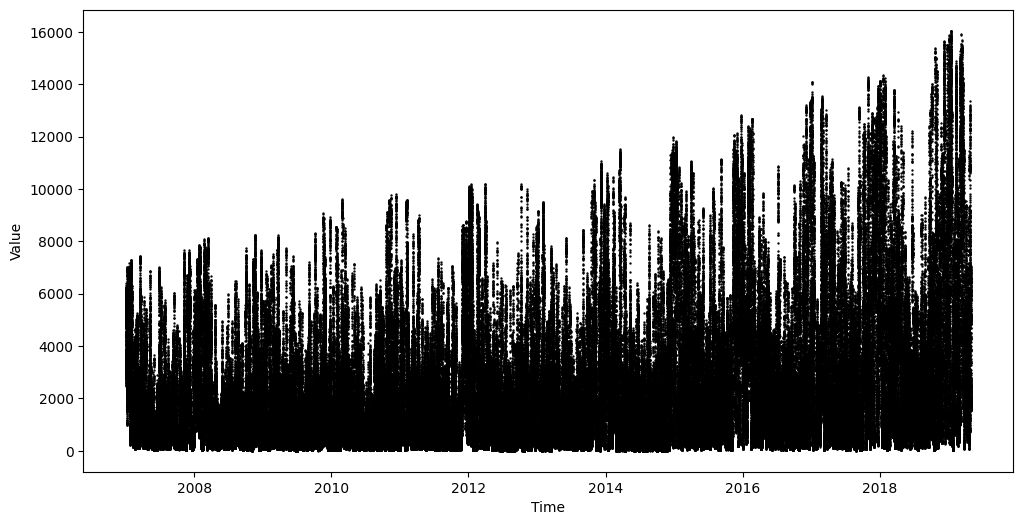

In [58]:
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Value'], s=0.5, color='black')
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

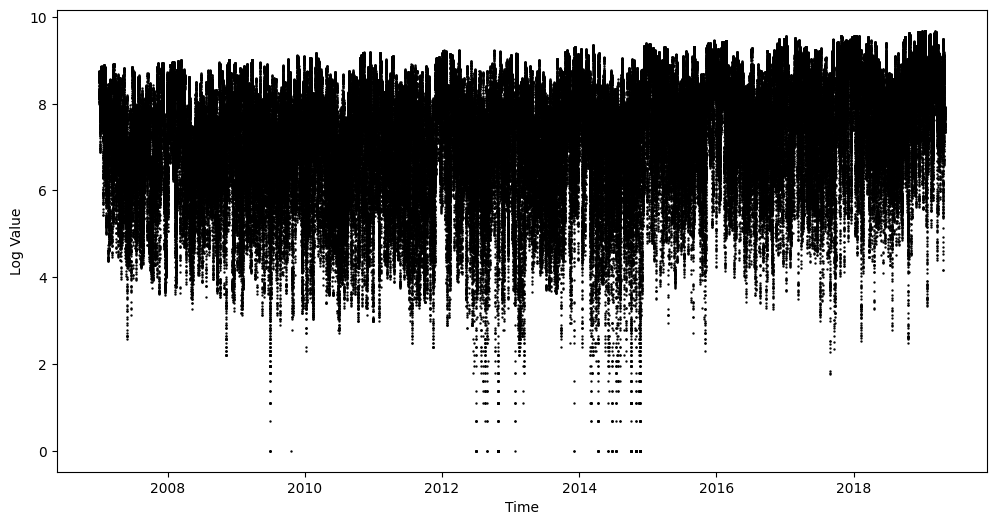

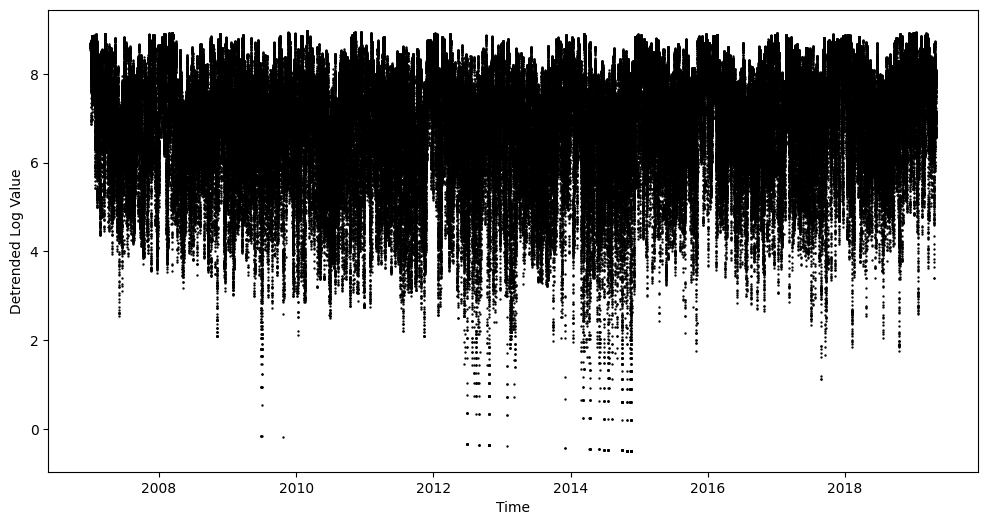

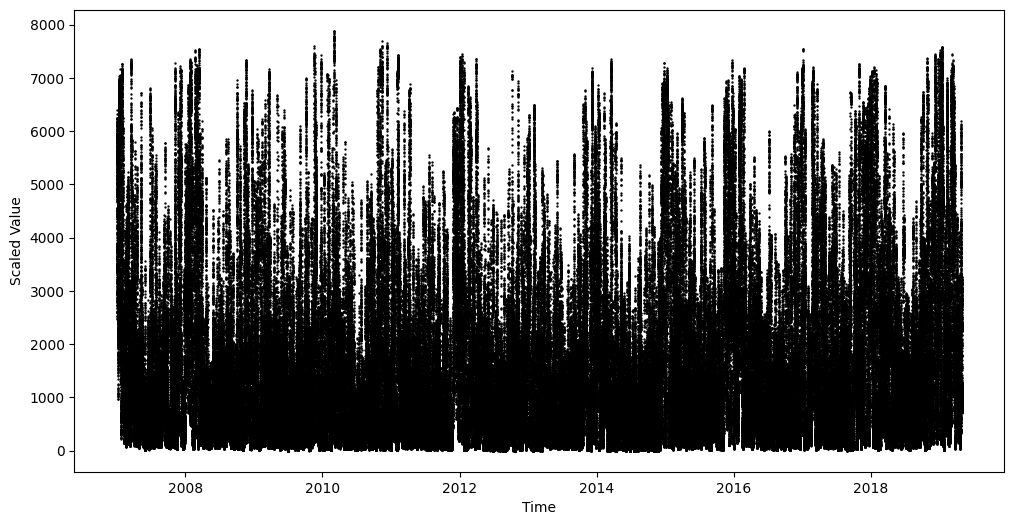

In [59]:
df['Log Value'] = np.log(df['Value'] + 1)

tmp_values = df['Log Value'].rolling(window=24*4*30).quantile(.99).dropna().to_numpy()
t = np.arange(len(tmp_values))
m, c = np.polyfit(t, tmp_values, 1)

plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Log Value'], s=0.5, color='black')
plt.xlabel("Time")
plt.ylabel("Log Value")
plt.show()

df['Log Value'] = df['Log Value'] - m*np.arange(len(df['Log Value']))
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Log Value'], s=0.5, color='black')
plt.xlabel("Time")
plt.ylabel("Detrended Log Value")
plt.show()

df['Scaled Value'] = np.exp(df['Log Value']) - 1
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Scaled Value'], s=0.5, color='black')
plt.xlabel("Time")
plt.ylabel("Scaled Value")
plt.show()

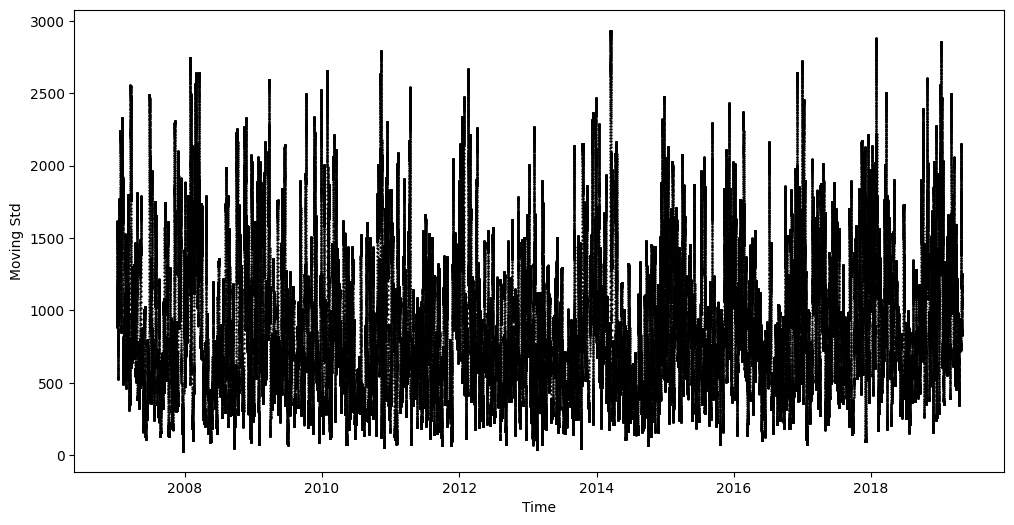

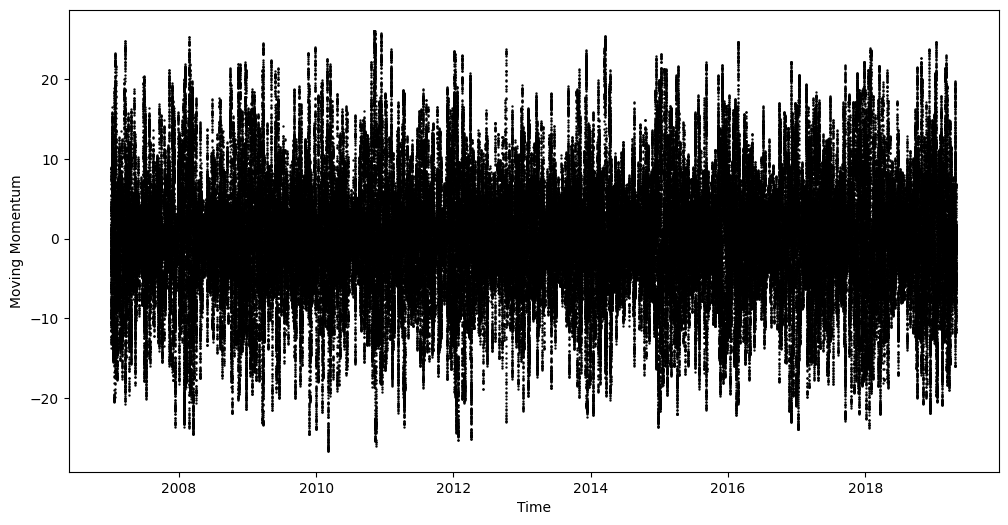

In [60]:
window = 24*4*3
df['Moving Std'] = df['Scaled Value'].rolling(window=window).std()
df['Moving Momentum'] = df['Scaled Value'].rolling(window=window).apply(lambda x: np.mean(np.diff(x)))
df.dropna(inplace=True)

plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Moving Std'], s=0.5, color='black')
plt.xlabel("Time")
plt.ylabel("Moving Std")
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Moving Momentum'], s=0.5, color='black')
plt.xlabel("Time")
plt.ylabel("Moving Momentum")
plt.show()

In [61]:
X = df[['Moving Std', 'Moving Momentum']].values
X = (X - X.mean(axis=0)) / X.std(axis=0)
model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)
model.fit(X)

df["Regime"] = model.predict(X)
df['Regime'] = df['Regime'].shift(-window // 2)
df['Regime'] = df['Regime'].ffill()

In [62]:
with open('../models/hmm.pkl', 'wb') as f:
    pickle.dump(model, f)

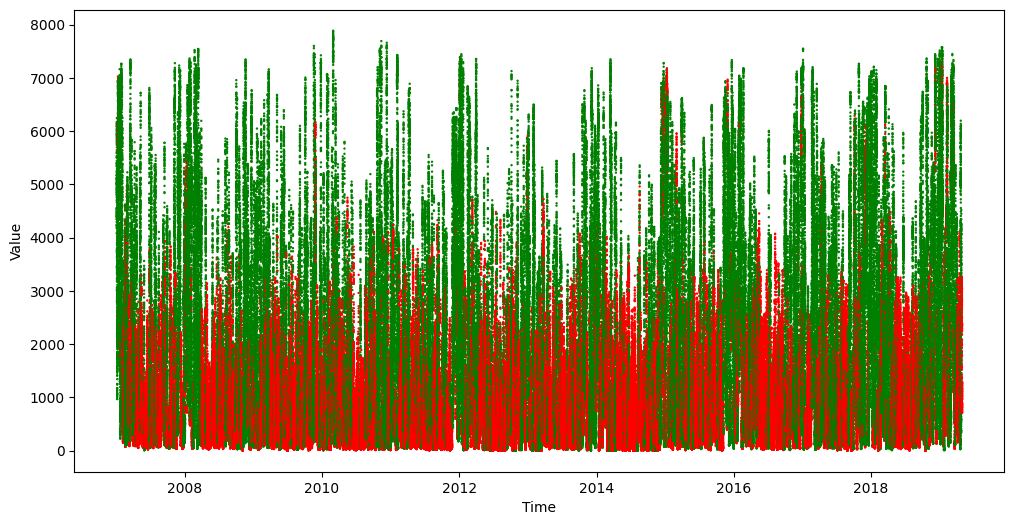

In [63]:
color_mapping = {0: 'r', 1: 'g'}

df['Color'] = df['Regime'].map(color_mapping)

plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Scaled Value'], c=df['Color'], s=0.5)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

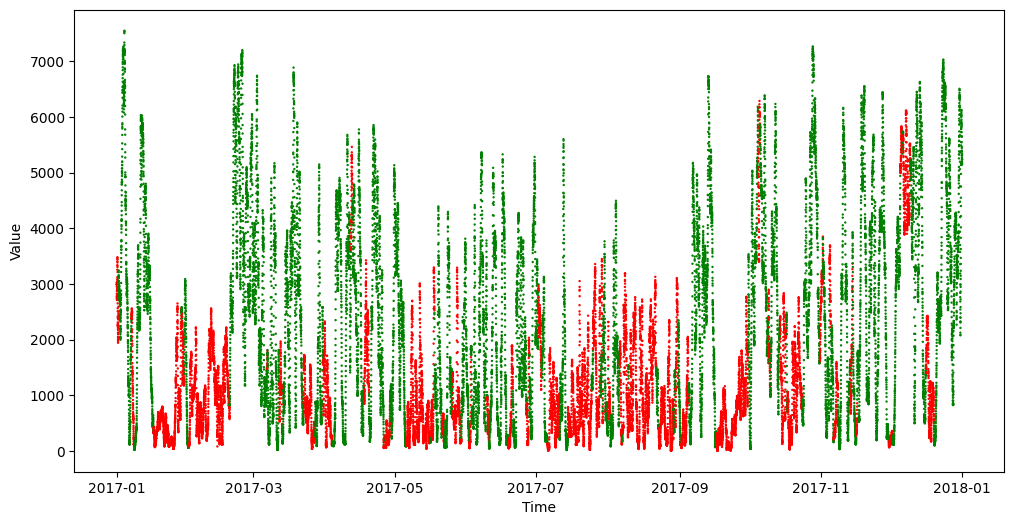

In [64]:
df_2017 = df[df.index.year == 2017]

plt.figure(figsize=(12, 6))
plt.scatter(df_2017.index, df_2017['Scaled Value'], c=df_2017['Color'], s=0.5)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [65]:
df['Day'] = df.index.date
daily_df = pd.DataFrame(df.groupby('Day')['Regime'].value_counts(normalize=True).unstack())
daily_df.fillna(0, inplace=True)
daily_df.index = pd.to_datetime(daily_df.index)

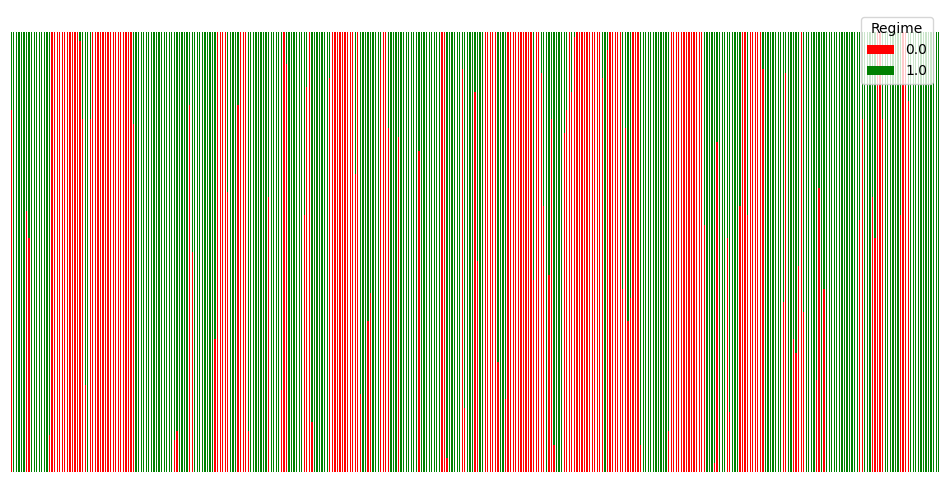

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))
daily_df[daily_df.index.year == 2017].plot(kind='bar', stacked=True, ax=ax, color=['r', 'g'])
ax.axis('off');

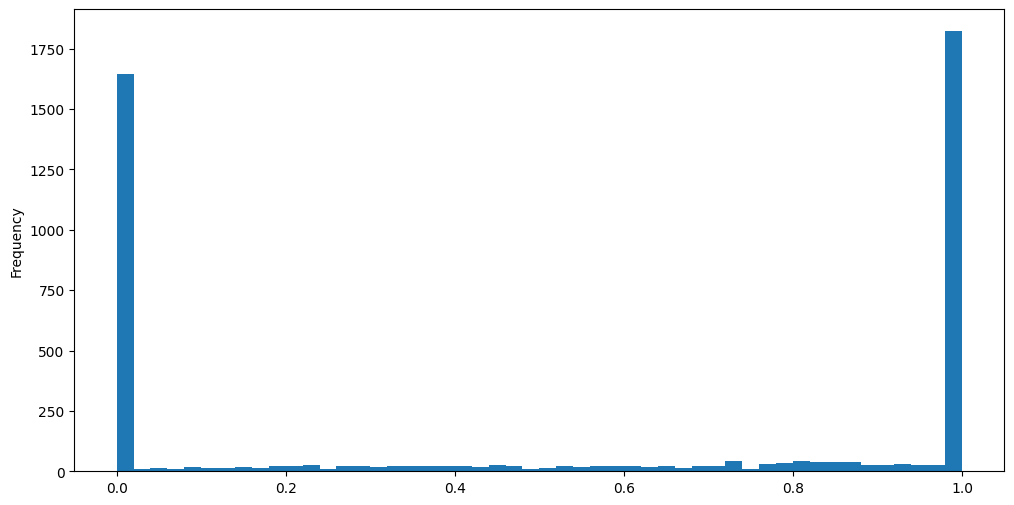

In [67]:
daily_df[0].plot(kind='hist', figsize=(12, 6), bins=50);

In [68]:
daily_df['Regime'] = (daily_df[0] > daily_df[1]).astype(int)
daily_df['Regime'].value_counts()

Regime
1    2431
0    2070
Name: count, dtype: int64

In [69]:
daily_df = daily_df[['Regime']].join(df.groupby('Day')['Scaled Value'].apply(lambda df: df.reset_index(drop=True)).unstack())
daily_df.dropna(inplace=True)
daily_df

,Regime,0,1,2,3,4,5,6,7,8,...,86,87,88,89,90,91,92,93,94,95
Day,,,,,,,,,,,,,,,,,,,,,
2007-01-04,0,4555.664883,4349.762656,4346.756464,4447.696459,4515.653232,4405.702517,4389.703043,4417.680542,4411.675841,...,5923.057305,5884.072775,5802.117135,5948.008929,6079.909615,6092.890035,6137.848786,6172.814151,6036.895556,5941.949519
2007-01-05,0,5819.022940,6005.884557,6243.710501,6137.772342,6119.773841,6098.777480,6029.814483,6117.742567,6164.698919,...,3465.100798,3598.982404,3774.828283,3736.853527,3755.830864,3765.815734,3731.837811,3762.804877,3792.772682,3753.799152
2007-01-06,0,3652.878678,3698.832834,3732.797112,3805.727773,3729.786409,3704.801333,3780.729062,3726.769097,3733.756391,...,1806.179485,1838.144010,1934.043786,1946.028203,1963.007510,2007.958330,2105.855088,2053.904318,2070.883312,2215.731385
2007-01-07,0,2427.510324,2516.414698,2539.386583,2535.386181,2500.417763,2762.142661,2693.209147,2499.405450,2394.510029,...,2938.536219,2924.547492,2991.463194,3061.375110,3038.396896,3022.410463,2702.785122,2468.059819,2249.316293,2306.244292
2007-01-08,0,2434.087263,2455.057805,2444.066617,2571.908660,2581.892065,2680.768313,2610.847919,2691.745493,2785.627062,...,2397.763264,2701.348812,2775.244025,2727.304023,2784.221956,2924.027105,3109.769281,3317.480877,3369.404164,3387.373625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-26,0,3336.123026,3267.612199,3206.766086,3110.733641,3024.791531,2958.313935,2892.363524,2745.685946,2644.744270,...,3735.015395,3661.628241,3582.007933,3506.191027,3490.689426,3513.692928,3484.485837,3437.371391,3387.338940,3255.604956
2019-04-27,0,3177.692783,2975.712865,2840.074761,2887.273454,2812.352055,2644.156328,2491.338428,2344.622143,2290.882265,...,907.707350,910.369790,882.303114,885.564710,926.280086,969.487318,997.283348,999.345556,997.707338,993.868354
2019-04-28,1,1026.618884,1086.404933,1149.020317,1215.832495,1255.969709,1277.933219,1266.939280,1267.215247,1246.065798,...,1289.917154,1335.323121,1381.792975,1428.435136,1519.730354,1583.480233,1556.592663,1557.394760,1624.112870,1699.160348


In [70]:
regimes = daily_df['Regime'].values
transition_matrix = np.zeros((2, 2))
for i in range(1, len(regimes)):
    transition_matrix[regimes[i-1], regimes[i]] += 1
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)
transition_matrix

array([[0.81440309, 0.18559691],
       [0.15761317, 0.84238683]])

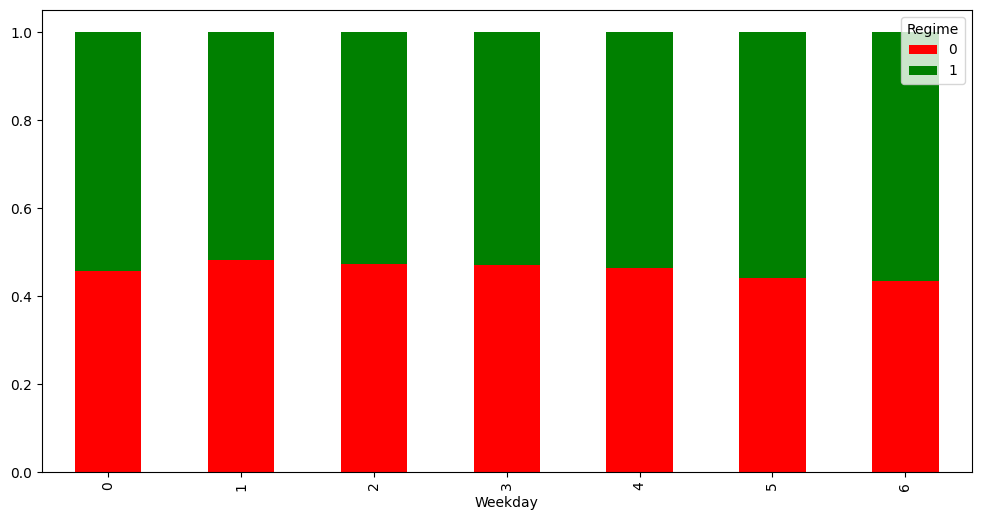

In [71]:
daily_df['Weekday'] = daily_df.index.day_of_week

daily_df.groupby('Weekday')['Regime'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, figsize=(12, 6), color=['r', 'g']);

In [72]:
daily_df['Day of Year'] = daily_df.index.day_of_year

In [73]:
np.save('../data/X.npy', daily_df[list(range(96))].to_numpy())
np.save('../data/y.npy', daily_df['Regime'].to_numpy())
np.save('../data/day.npy', daily_df['Day of Year'].to_numpy())